In [21]:
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.ml import pipeline
from pyspark.sql import functions as fn
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import when, lit, col,isnull,split, udf
from pyspark.ml.feature import StringIndexer,  VectorAssembler, OneHotEncoder
from pyspark.sql.functions import year, month, dayofmonth, hour
from pyspark.ml.feature import Bucketizer, VectorSlicer
from pyspark.sql.types import *
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import PCA
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml import classification
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [22]:
#Read the csv file
data = spark.read.csv('data.csv',inferSchema=True, header=True)

In [23]:
data.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Crash Descriptor: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day of Week: string (nullable = true)
 |-- Police Report: string (nullable = true)
 |-- Lighting Conditions: string (nullable = true)
 |-- Municipality: string (nullable = true)
 |-- Collision Type Descriptor: string (nullable = true)
 |-- County Name: string (nullable = true)
 |-- Road Descriptor: string (nullable = true)
 |-- Weather Conditions: string (nullable = true)
 |-- Traffic Control Device: string (nullable = true)
 |-- Road Surface Conditions: string (nullable = true)
 |-- DOT Reference Marker Location: string (nullable = true)
 |-- Pedestrian Bicyclist Action: string (nullable = true)
 |-- Event Descriptor: string (nullable = true)
 |-- Number of Vehicles Involved: integer (nullable = true)



In [24]:
# Label the rows with injury accident = 1 and property damage accident = 0
df = data.withColumn('AccidentDescriptor', 
                     when((data['Crash Descriptor'] == 'Property Damage & Injury Accident') | 
                          (data['Crash Descriptor'] == 'Injury Accident')| 
                          (data['Crash Descriptor'] == 'Fatal Accident'), 1).otherwise(0).cast("double"))

In [25]:
## HOUR BUCKETIZER

#Extract the hour from the time column
df = df.withColumn('Hour', hour('Time'))

#Bucket the hour column: 
# 5 Buckets: 0-4a.m. = 0.0, 5-11 = 1.0, 12-16 = 2.0, 17-22 = 3.0, 23-24 = 4.0
# 5 Buckets: 0-4 = Night, 5-11 = Morning, 12-16 = Afternoon, 17-22 = Evening, 23-34 = Night

bucketizer = Bucketizer(splits=[0,5,12,17,23,24],inputCol="Hour", outputCol="Hour_buckets")
df = bucketizer.setHandleInvalid("keep").transform(df)

# convert 5 buckets into 4 buckets (we have twice Night): 1.0 = Morning, 2.0 = Afternoon, 3.0 = Evening, 4.0 = Night
t = {0.0:4, 1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4}
udf_foo = udf(lambda x: t[x], IntegerType())
df = df.withColumn("Hour", udf_foo("Hour_buckets"))

#Extract the month from the Date column
df = df.withColumn('Month', split(df['Date'], '/')[0])
df = df.withColumn('Month',df.Month.cast('int'))


In [26]:
# removing features
df= df.drop('Time','Date','Hour_buckets','Municipality','DOT Reference Marker Location', 'Crash Descriptor',
            'Number of Vehicles Involved', 'Year', 'Police Report', 'Pedestrian Bicyclist Action', 'Event Descriptor')

# let us take a look at it with pandas
df_pd = df.toPandas()

In [27]:
# display table
df_pd.T

,0,1,2,3,4,5,6,7,8,9,...,895906,895907,895908,895909,895910,895911,895912,895913,895914,895915
Day of Week,Saturday,Saturday,Saturday,Saturday,Saturday,Saturday,Saturday,Saturday,Saturday,Saturday,...,Wednesday,Wednesday,Wednesday,Wednesday,Wednesday,Wednesday,Wednesday,Wednesday,Wednesday,Wednesday
Lighting Conditions,Dark-Road Unlighted,Dark-Road Unlighted,Daylight,Unknown,Daylight,Dusk,Daylight,Daylight,Daylight,Dark-Road Lighted,...,Dark-Road Unlighted,Daylight,Dark-Road Lighted,Dark-Road Lighted,Daylight,Dark-Road Lighted,Unknown,Daylight,Daylight,Daylight
Collision Type Descriptor,OTHER,SIDESWIPE,LEFT TURN (3),Unknown,LEFT TURN (3),OTHER,OTHER,REAR END,REAR END,RIGHT ANGLE,...,OTHER,RIGHT ANGLE,Unknown,OVERTAKING,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER
County Name,LEWIS,SUFFOLK,OTSEGO,KINGS,RENSSELAER,ERIE,ALBANY,WESTCHESTER,GREENE,NASSAU,...,OTSEGO,SUFFOLK,BRONX,KINGS,ERIE,ERIE,MONROE,ROCKLAND,QUEENS,SUFFOLK
Road Descriptor,Curve and Grade,Straight and Level,Straight and Level,Unknown,Straight and Grade,Straight and Grade,Curve and Level,Curve and Level,Straight at Hill Crest,Straight and Level,...,Curve and Level,Straight and Level,Straight at Hill Crest,Straight and Level,Curve and Level,Straight and Level,Unknown,Straight and Level,Straight and Level,Straight and Level
Weather Conditions,Cloudy,Clear,Cloudy,Unknown,Clear,Clear,Clear,Clear,Cloudy,Clear,...,Snow,Clear,Clear,Clear,Clear,Clear,Unknown,Clear,Clear,Cloudy
Traffic Control Device,None,None,No Passing Zone,Unknown,Traffic Signal,Unknown,None,None,None,None,...,No Passing Zone,Stop Sign,None,None,None,None,Unknown,None,Traffic Signal,None
Road Surface Conditions,Wet,Dry,Wet,Unknown,Dry,Snow/Ice,Snow/Ice,Dry,Snow/Ice,Dry,...,Snow/Ice,Dry,Dry,Dry,Snow/Ice,Wet,Unknown,Dry,Dry,Dry
AccidentDescriptor,0,0,1,1,0,0,1,1,0,1,...,0,0,1,0,0,1,0,1,0,0
Hour,3,1,1,2,1,3,1,2,2,3,...,3,1,3,1,1,4,3,2,1,2


In [28]:
#Using StringIndexer to change the column as categorical variable 
#or to convert the textual data to numeric data keeping the categorical context.

pipe_feat= Pipeline(stages=[StringIndexer(inputCol = 'Day of Week', outputCol = 'Day of Week_index'),
                            StringIndexer(inputCol = 'Lighting Conditions', outputCol = 'Lighting Conditions_index'),
                            StringIndexer(inputCol = 'Collision Type Descriptor', outputCol = 'Collision Type Descriptor_index'),
                            StringIndexer(inputCol = 'County Name', outputCol = 'County Name_index'),
                            StringIndexer(inputCol = 'Road Descriptor', outputCol = 'Road Descriptor_index'),
                            StringIndexer(inputCol = 'Weather Conditions', outputCol = 'Weather Conditions_index'),
                            StringIndexer(inputCol = 'Traffic Control Device', outputCol = 'Traffic Control Device_index'),
                            StringIndexer(inputCol = 'Road Surface Conditions', outputCol = 'Road Surface Conditions_index'),
                            StringIndexer(inputCol = 'Hour', outputCol = 'Hour_index'),
                            StringIndexer(inputCol = 'Month', outputCol = 'Month_index'),
                            OneHotEncoder(inputCol = 'Day of Week_index', outputCol = 'Day of Week_feat', dropLast=False),
                            OneHotEncoder(inputCol = 'Lighting Conditions_index', outputCol = 'Lighting Conditions_feat', dropLast=False),
                            OneHotEncoder(inputCol = 'Collision Type Descriptor_index', outputCol = 'Collision Type Descriptor_feat', dropLast=False),
                            OneHotEncoder(inputCol = 'County Name_index', outputCol = 'County Name_feat', dropLast=False),
                            OneHotEncoder(inputCol = 'Road Descriptor_index', outputCol = 'Road Descriptor_feat', dropLast=False),
                            OneHotEncoder(inputCol = 'Weather Conditions_index', outputCol = 'Weather Conditions_feat', dropLast=False),
                            OneHotEncoder(inputCol = 'Traffic Control Device_index', outputCol = 'Traffic Control Device_feat', dropLast=False),
                            OneHotEncoder(inputCol = 'Road Surface Conditions_index', outputCol = 'Road Surface Conditions_feat', dropLast=False),
                            OneHotEncoder(inputCol = 'Hour_index', outputCol = 'Hour_feat', dropLast=False),
                            OneHotEncoder(inputCol = 'Month_index', outputCol = 'Month_feat', dropLast=False),
                            VectorAssembler(inputCols=['Day of Week_feat','Lighting Conditions_feat','Collision Type Descriptor_feat',
                                                    'County Name_feat', 'Road Descriptor_feat','Weather Conditions_feat','Traffic Control Device_feat',
                                                     'Road Surface Conditions_feat','Hour_feat','Month_feat'], outputCol = 'features',handleInvalid="keep")]).fit(df)

In [29]:
#Transforming the model
df_feat = pipe_feat.transform(df)

In [30]:
#Checking the number of features present
df_feat.groupby('Day of Week_feat').count().show()

+----------------+------+
|Day of Week_feat| count|
+----------------+------+
|   (7,[6],[1.0])|100708|
|   (7,[1],[1.0])|135332|
|   (7,[2],[1.0])|132954|
|   (7,[4],[1.0])|128593|
|   (7,[5],[1.0])|118697|
|   (7,[0],[1.0])|147681|
|   (7,[3],[1.0])|131951|
+----------------+------+



In [31]:
#Creating a data split
training_df, validation_df, testing_df = df_feat.randomSplit([0.6, 0.3, 0.1], seed=0)

In [32]:
#logistic Regression model using all 145 features
pipe_lr = Pipeline(stages=[classification.LogisticRegression(labelCol='AccidentDescriptor', featuresCol='features',regParam = 0.1,elasticNetParam = 0.001)])

In [33]:
#Random forest model using all 145 features
pipe_rf = Pipeline(stages=[classification.RandomForestClassifier(labelCol='AccidentDescriptor', featuresCol='features',numTrees = 20,maxDepth = 6)])


In [34]:
#Gradient boosting model using all 145 features
pipe_gbt = Pipeline(stages=[classification.GBTClassifier(labelCol='AccidentDescriptor', featuresCol='features',maxIter = 10)])

In [35]:
#Creating the Lr model
fit_lr = pipe_lr.fit(training_df)
#Transforming the LR model to dataframe
dataframe_lr = fit_lr.transform(validation_df)

#Creating the RF model
fit_rf = pipe_rf.fit(training_df)
#Transforming the RF model to dataframe
dataframe_rf = fit_rf.transform(validation_df)

#Creating the GBT model
fit_gbt = pipe_gbt.fit(training_df)
#Transforming the GBT model to dataframe
dataframe_gbt = fit_gbt.transform(validation_df)

In [36]:
fit_rf = pipe_rf.fit(training_df)

In [37]:
#Using Binary Classification Evaluator as the evaluation metric
evaluator = evaluation.BinaryClassificationEvaluator(labelCol='AccidentDescriptor')
AUC_LR = evaluator.evaluate(dataframe_lr)
AUC_RF = evaluator.evaluate(dataframe_rf)
AUC_GBT = evaluator.evaluate(dataframe_gbt)
#print the AUC of all models
print("The AUC of LR :", AUC_LR) 
print("The AUC of RF :", AUC_RF)
print("The AUC of GBT :", AUC_GBT)

The AUC of LR : 0.7454821500807303
The AUC of RF : 0.7232604893767578
The AUC of GBT : 0.7379352101600039


In [38]:
#Assinging the best model to LR
best_lr_allfeat = fit_lr
#Performing Testing on the testing dataframe 
testdf_lr = best_lr_allfeat.transform(testing_df)
AUC_best_LR = evaluator.evaluate(testdf_lr)

In [39]:
print("The AUC of the best model for all features :", AUC_best_LR)

The AUC of the best model for all features : 0.7447733277861671


In [40]:
#Creaing a model to visulize ROC
lr = classification.LogisticRegression(labelCol='AccidentDescriptor', featuresCol='features',regParam = 0.1,elasticNetParam = 0.001)
LR_model = lr.fit(training_df)


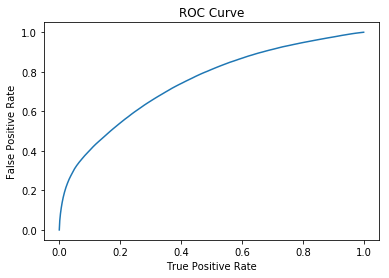

Training set AUC_LR: 0.7448716658867336


In [41]:
#Using Pandas to find the FPR and TPR
trainingSummary = LR_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set AUC_LR: ' + str(trainingSummary.areaUnderROC))

In [42]:
#Predicting the precision,recall and f score of the best model which is LR using all features
tp = testdf_lr[(testdf_lr.AccidentDescriptor == 1) & (testdf_lr.prediction == 1)].count()
tn = testdf_lr[(testdf_lr.AccidentDescriptor == 0) & (testdf_lr.prediction == 0)].count()
fp = testdf_lr[(testdf_lr.AccidentDescriptor == 0) & (testdf_lr.prediction == 1)].count()
fn = testdf_lr[(testdf_lr.AccidentDescriptor == 1) & (testdf_lr.prediction == 0)].count()

In [43]:
r = float(tp)/(tp + fn)
print ("Recall:", r)

p = float(tp) / (tp + fp)
print ("Precision:", p)

f1score = float(2*((p*r)/(p+r)))
print ("F1score:", f1score)

Recall: 0.4081745526948923
Precision: 0.7250577197032961
F1score: 0.5223114759899501


In [44]:
#Listing the name of the features
df_feature =[ ]
label1 = pipe_feat.stages[0].labels
for i in label1:
    lab1 = i.replace(' ','_')
    df_feature.append('Day of Week_'+lab1)
label2 = pipe_feat.stages[1].labels
for i in label2:
    lab2 = i.replace(' ','_')
    df_feature.append('Lighting Conditions_'+lab2)
label3 = pipe_feat.stages[2].labels
for i in label3:
    lab3 = i.replace(' ','_')
    df_feature.append('Collision Type Descriptor_'+lab3)
label4 = pipe_feat.stages[3].labels
for i in label4:
    lab4 = i.replace(' ','_')
    df_feature.append('County Name_'+lab4)
label5 = pipe_feat.stages[4].labels
for i in label5:
    lab5 = i.replace(' ','_')
    df_feature.append('Road Descriptor_'+lab5)
label6 = pipe_feat.stages[5].labels
for i in label6:
    lab6= i.replace(' ','_')
    df_feature.append('Weather Conditions_'+lab6)
label7 = pipe_feat.stages[6].labels
for i in label7:
    lab7= i.replace(' ','_')
    df_feature.append('Traffic Control Device_'+lab7)
label8 = pipe_feat.stages[7].labels
for i in label8:
    lab8= i.replace(' ','_')
    df_feature.append('Road Surface Conditions_'+lab8)
label9 = pipe_feat.stages[8].labels
for i in label9:
    lab9= i.replace(' ','_')
    df_feature.append('Hour_'+lab9)
label10 = pipe_feat.stages[9].labels
for i in label10:
    lab10= i.replace(' ','_')
    df_feature.append('Month_'+lab10)


In [45]:
#Exctrating the coefficients of the Logistic Regression model
lrmcoeff = fit_lr.stages[-1].coefficients

In [46]:
#Checking if the number of features and coefficients are equal
len(lrmcoeff),len(df_feature)

(145, 145)

In [47]:
#Creating a dataframe for the coeff and the features
lr_coeff_feature = spark.createDataFrame([(tup[0], float(tup[1])) for tup in list(zip(df_feature , lrmcoeff))],['feature', 'LR Coeff']).sort('LR Coeff', ascending=False)
lr_coeff_feature.show(145,False)

+-------------------------------------------------------------+---------------------+
|feature                                                      |LR Coeff             |
+-------------------------------------------------------------+---------------------+
|County Name_BRONX                                            |1.0086890722086685   |
|County Name_KINGS                                            |0.9702974209013482   |
|County Name_QUEENS                                           |0.8420003729498119   |
|County Name_NEW_YORK                                         |0.7131575078536844   |
|Collision Type Descriptor_HEAD_ON                            |0.6758562947681976   |
|County Name_RICHMOND                                         |0.6576132538580078   |
|Traffic Control Device_Traffic_Signal                        |0.3592865083616503   |
|Traffic Control Device_Flashing_Light                        |0.3137430207704314   |
|Collision Type Descriptor_OTHER                      

In [48]:
#Extracting the feature importance score from the random forest model
importance= fit_rf.stages[-1].featureImportances.toArray()

In [49]:
#Creating a dataframe with the name of the feature and the importance
feature_importance =pd.DataFrame(list(zip(df_feature, importance)),columns = ['feature', 'importance']).sort_values('importance', ascending=False)

In [50]:
len(feature_importance)

145

In [51]:
#Extracting the index of the top 100 feature important score to use it in the vector slicer 
idx= list(feature_importance.index)     
feature_importance['IDX'] = idx
varidx = [x for x in feature_importance['IDX'][0:100]]
#varidx

In [52]:
#Performed feature selection by using Vector Slice on the features 
slicer = VectorSlicer(inputCol="features", outputCol="features_Rf", indices=varidx)
#Transforming the baseline dataframe to a new dataframe that consists of the top 100 features
df_slicer = slicer.transform(df_feat)

In [53]:
#Performing data split
training_feat, validation_feat, testing_feat = df_slicer.randomSplit([0.6, 0.3, 0.1], seed=0)

In [54]:
#Creating a Logistic Regression model with the sliced features
pipe_lr_feat = Pipeline(stages=[classification.LogisticRegression(labelCol='AccidentDescriptor', featuresCol='features_Rf',regParam = 0.1,elasticNetParam = 0.001)])
fit_lr_feat = pipe_lr_feat.fit(training_feat)
dataframe_lr_feat = fit_lr_feat.transform(validation_feat)
AUC_LR_feat = evaluator.evaluate(dataframe_lr_feat)
AUC_LR_feat 

0.7402455273204198

In [55]:
#Creating a Random Forest model with the sliced features
pipe_rf_feat = Pipeline(stages=[classification.RandomForestClassifier(labelCol='AccidentDescriptor', featuresCol='features_Rf',numTrees = 20,maxDepth = 6)])
fit_rf_feat = pipe_rf_feat.fit(training_feat)
dataframe_rf_feat = fit_rf_feat.transform(validation_feat)
AUC_RF_feat = evaluator.evaluate(dataframe_rf_feat)
AUC_RF_feat 

In [56]:
#Creating a Gradient Boosting model with the sliced features
pipe_gbt_feat = Pipeline(stages=[classification.GBTClassifier(labelCol='AccidentDescriptor', featuresCol='features_Rf',maxIter = 10)])
fit_gbt_feat = pipe_gbt_feat.fit(training_feat)
dataframe_gbt_feat = fit_gbt_feat.transform(validation_feat)
AUC_GBT_feat = evaluator.evaluate(dataframe_gbt_feat)
AUC_GBT_feat 

0.7379427168247586

In [57]:
#print the AUC of all models after using Vector Slicer feature selection technique
print("The AUC of LR  :", AUC_LR_feat) 
print("The AUC of RF :", AUC_RF_feat)
print("The AUC of GBT :", AUC_GBT_feat)

The AUC of LR  : 0.7402455273204198
The AUC of RF : 0.7179963800296109
The AUC of GBT : 0.7379427168247586


In [58]:
#AUC of the best model
#Assinging the best model to LR
best_LR_VS = fit_lr_feat
#Performing Testing on the testing dataframe 
testdf_LR = best_LR_VS.transform(testing_feat)
#AUC_best_LR = evaluator.evaluate(testdf_LR)

In [59]:

pipe_lr_feat = Pipeline(stages=[classification.LogisticRegression(labelCol='AccidentDescriptor', featuresCol='features_Rf',regParam = 0.1,elasticNetParam = 0.001)])
fit_lr_feat = pipe_lr_feat.fit(training_feat)
best_LR_VS = fit_lr_feat
#Performing Testing on the testing dataframe 
testdf_LR = best_LR_VS.transform(testing_feat)
AUC_best_LR = evaluator.evaluate(testdf_LR)
AUC_best_LR

0.739915502412174

In [60]:
testdf_LR.select('features_Rf').show(5,False)

+-----------------------------------------------------------------------+
|features_Rf                                                            |
+-----------------------------------------------------------------------+
|(100,[9,10,15,16,18,23,40,53,83],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(100,[0,9,10,16,18,25,53,89],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])        |
|(100,[0,9,10,16,18,25,30,53,65],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|(100,[9,13,16,18,22,24,56,64,78],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(100,[7,9,10,15,16,18,22,37,61],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
+-----------------------------------------------------------------------+
only showing top 5 rows



In [61]:
print("The AUC of the best model after vector slicing :", AUC_best_LR)

The AUC of the best model after vector slicing : 0.739915502412174


In [62]:
#Checking the f1score, Precision and Recall for the best model
tp1 = testdf_LR[(testdf_LR.AccidentDescriptor == 1) & (testdf_LR.prediction == 1)].count()
tn1 = testdf_LR[(testdf_LR.AccidentDescriptor == 0) & (testdf_LR.prediction == 0)].count()
fp1 = testdf_LR[(testdf_LR.AccidentDescriptor == 0) & (testdf_LR.prediction == 1)].count()
fn1 = testdf_LR[(testdf_LR.AccidentDescriptor == 1) & (testdf_LR.prediction == 0)].count()


In [63]:
r1 = float(tp1)/(tp1 + fn1)
print ("Recall:", r1)

p1 = float(tp) / (tp1 + fp1)
print ("Precision:", p1)

f1score1 = float(2*((p1*r1)/(p1+r1)))
print ("F1score:", f1score1)

Recall: 0.40148225989325514
Precision: 0.7368946580129805
F1score: 0.5197753537492


In [64]:
#Performing PCA for dimensionality reduction
pipe_pca = Pipeline(stages=[feature.VectorAssembler(inputCols= ['Day of Week_feat',
 'Lighting Conditions_feat',
 'Collision Type Descriptor_feat',
 'County Name_feat',
 'Road Descriptor_feat',
 'Weather Conditions_feat',
 'Traffic Control Device_feat',
 'Road Surface Conditions_feat',
 'Hour',
 'Month'], outputCol = 'pcafeatures'), feature.PCA(k=15, inputCol='pcafeatures',outputCol='pc')]).fit(df_feat)


In [65]:
#Transforming to a dataframe with pca features
pc_df= pipe_pca.transform(df_feat)
training_pc, validation_pc, testing_pc = pc_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [66]:
#Logistic Regression with pca features
pipe_lr_pc = Pipeline(stages=[classification.LogisticRegression(labelCol='AccidentDescriptor', featuresCol='pc',regParam = 0.1,elasticNetParam = 0.001)]).fit(training_pc)
pc_pred = pipe_lr_pc.transform(validation_pc)
evaluator = evaluation.BinaryClassificationEvaluator(labelCol='AccidentDescriptor')
AUC_LR_pc = evaluator.evaluate(pc_pred)
AUC_LR_pc

0.6342795371266332

In [67]:
#Random forest with pca features
pipe_rf_pc = Pipeline(stages=[classification.RandomForestClassifier(labelCol='AccidentDescriptor', featuresCol='pc',numTrees = 20,maxDepth = 6)]).fit(training_pc)
pc_pred_rf = pipe_rf_pc.transform(validation_pc)
AUC_RF_pc = evaluator.evaluate(pc_pred_rf)
AUC_RF_pc


0.6780532880169272

In [68]:
#Gradient boosting with pca features
pipe_gbt_pc = Pipeline(stages=[classification.GBTClassifier(labelCol='AccidentDescriptor', featuresCol='pc',maxIter = 10)]).fit(training_pc)
pc_pred_gbt = pipe_gbt_pc.transform(validation_pc)
AUC_GBT_pc = evaluator.evaluate(pc_pred_gbt)
AUC_GBT_pc

0.6868113110910181

In [69]:
pc_pred_test = pipe_gbt_pc.transform(testing_pc)
AUC_GBT_pc_test = evaluator.evaluate(pc_pred_test)
AUC_GBT_pc_test

0.6862694722986825

In [70]:
#print the AUC of all models on using pca features
print("The AUC of LR  :", AUC_LR_pc) 
print("The AUC of RF :", AUC_RF_pc)
print("The AUC of GBT :", AUC_GBT_pc)

The AUC of LR  : 0.6342795371266332
The AUC of RF : 0.6780532880169272
The AUC of GBT : 0.6868113110910181


In [71]:
pca_model = pipe_pca.stages[-1]
pc1 = abs(pca_model.pc.toArray()[:, 0]).tolist()
pc2 = abs(pca_model.pc.toArray()[:, 1]).tolist()
pc1_df = spark.createDataFrame(list(zip(df_feature , pc1)),['feature', 'loadings']).sort('loadings', ascending=False)
pc2_df = spark.createDataFrame(list(zip(df_feature , pc2)),['feature', 'loadings']).sort('loadings', ascending=False)

# pc1_df = pd.DataFrame(list(zip(df_feature , pc1)),columns = ['feature', 'loadings']).sort_values('loadings', ascending=False)
# pc2_df = pd.DataFrame(list(zip(df_feature , pc2)),columns = ['feature', 'loadings']).sort_values('loadings', ascending=False)


In [72]:
pc1_df.show(5,False)

+--------------------------------+--------------------+
|feature                         |loadings            |
+--------------------------------+--------------------+
|Hour_1                          |0.9993768546684467  |
|Road Surface Conditions_Snow/Ice|0.020382590787955034|
|Road Surface Conditions_Dry     |0.017515872197376787|
|Weather Conditions_Snow         |0.011091831440935777|
|Hour_2                          |0.010625329356173165|
+--------------------------------+--------------------+
only showing top 5 rows



In [73]:
pc2_df.show(5,False)

+---------------------------------------+-------------------+
|feature                                |loadings           |
+---------------------------------------+-------------------+
|Hour_2                                 |0.9081255530803639 |
|Lighting Conditions_Daylight           |0.3196763377727767 |
|Lighting Conditions_Dark-Road_Lighted  |0.17017860138086374|
|Lighting Conditions_Dark-Road_Unlighted|0.09039427394614218|
|Collision Type Descriptor_OTHER        |0.07310966950066805|
+---------------------------------------+-------------------+
only showing top 5 rows



In [74]:
test_df = spark.createDataFrame([
    ('Saturday','Daylight','SIDESWIPE','SUFFOLK','Curve and Grade','Cloudy','Traffic Signal','Wet',3,12)
], ['Day of Week',
 'Lighting Conditions',
 'Collision Type Descriptor',
 'County Name',
 'Road Descriptor',
 'Weather Conditions',
 'Traffic Control Device',
 'Road Surface Conditions',

 'Hour',
 'Month'])

In [75]:
test_df.show()

+-----------+-------------------+-------------------------+-----------+---------------+------------------+----------------------+-----------------------+----+-----+
|Day of Week|Lighting Conditions|Collision Type Descriptor|County Name|Road Descriptor|Weather Conditions|Traffic Control Device|Road Surface Conditions|Hour|Month|
+-----------+-------------------+-------------------------+-----------+---------------+------------------+----------------------+-----------------------+----+-----+
|   Saturday|           Daylight|                SIDESWIPE|    SUFFOLK|Curve and Grade|            Cloudy|        Traffic Signal|                    Wet|   3|   12|
+-----------+-------------------+-------------------------+-----------+---------------+------------------+----------------------+-----------------------+----+-----+



In [152]:
test_feat = pipe_feat.transform(test_df)

In [153]:
pc_test= pipe_pca.transform(test_feat)

In [154]:
pred = pipe_rf_pc.transform(pc_test)

In [155]:
pred.select('prediction').show()

+----------+
|prediction|
+----------+
|       0.0|
+----------+

